## Network Intrusion Detection using ML and XAI

### Final Review

Sonali Shripad Shanbhag, Anish Ralph Rodrigues

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("KDDtrain.csv")
test_df = pd.read_csv("KDDtest.csv")

In [3]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns


In [4]:
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack


Categorising the different attacks- using references:
http://45.113.122.54/pdfs/ijrscse/v2-i3/7.pdf 
https://lupinepublishers.com/computer-science-journal/fulltext/detecting-distributed-denial-of-service-ddos-attacks.ID.000110.php

In [5]:
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']


attack_labels = ['Normal','DoS','Probe','Privilege','Access']

In [6]:
def map_attack(attack):
    if attack in dos_attacks:
        attack_type = 1
    elif attack in probe_attacks:
        attack_type = 2
    elif attack in privilege_attacks:
        attack_type = 3
    elif attack in access_attacks:
        attack_type = 4
    else:
        attack_type = 0
    return attack_type

In [7]:
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map
test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map
df.head()

duration protocol_type  service flag  src_bytes  dst_bytes  land  \
0         0           udp    other   SF        146          0     0   
1         0           tcp  private   S0          0          0     0   
2         0           tcp     http   SF        232       8153     0   
3         0           tcp     http   SF        199        420     0   
4         0           tcp  private  REJ          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_src_port_rate  \
0               0       0    0  ...                         0.88   
1               0       0    0  ...                         0.00   
2               0       0    0  ...                         0.03   
3               0       0    0  ...                         0.00   
4               0       0    0  ...                         0.00   

   dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                         0.00                  0.00   
1                         0.00                  1.00   
2                         0.04                  0.03   
3                         0.00                  0.00   
4                         0.00                  0.00   

   dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate  \
0                      0.00                   0.0                      0.00   
1                      1.00                   0.0                      0.00   
2                      0.01                   0.0                      0.01   
3                      0.00                   0.0                      0.00   
4                      0.00                   1.0                      1.00   

    attack  level  attack_flag  attack_map  
0   normal     15            0           0  
1  neptune     19            1           1  
2   normal     21            0           0  
3   normal     21            0           0  
4  neptune     21            1           1  

[5 rows x 45 columns]

Understanding relationship and causality between attack and protocol

In [8]:
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)

In [9]:
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    for count, data_set in enumerate(data_list): 
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        axs[count].set_title(labels[count])
    return axs   

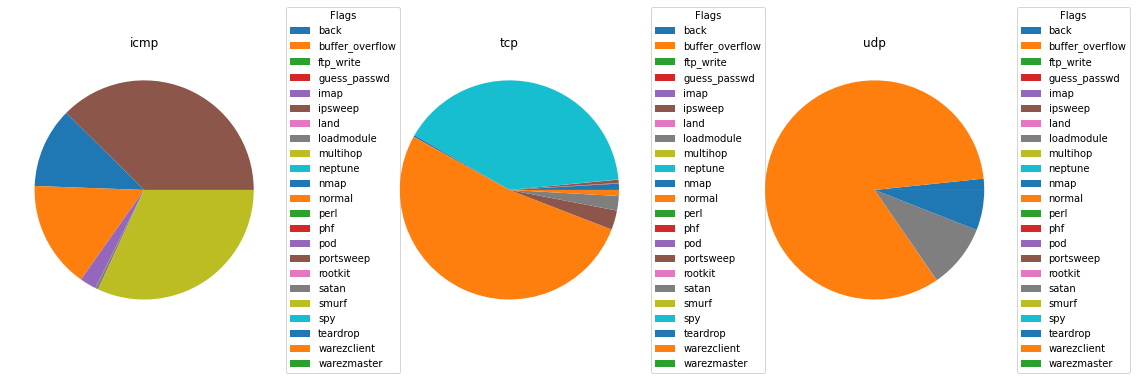

In [10]:
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

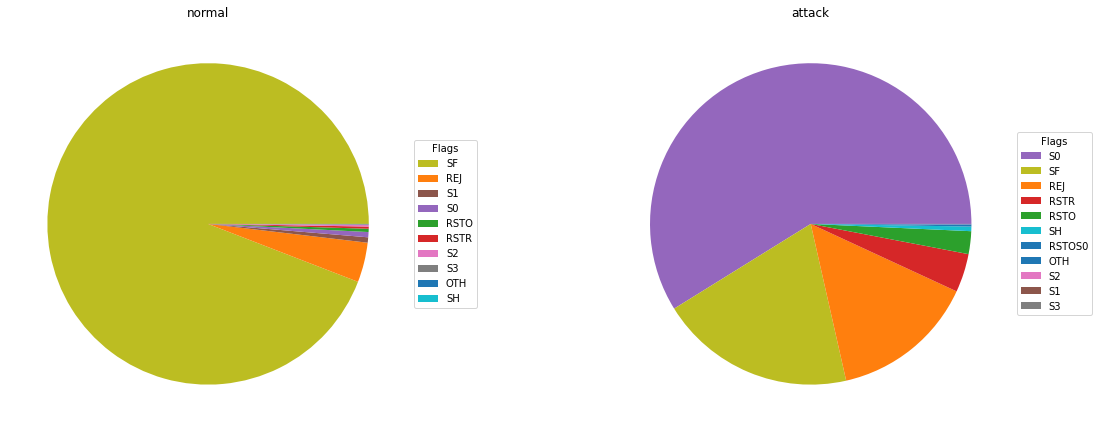

In [11]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

Feature engineering - Label encoding. pd.get_dummies is a method that allows us to do a quick one hot encoding on our columns. This takes every value it finds in a single column and makes an individual column for each value, with a 0 or 1 indicating whether that column is 'hot'.
We're also going to throw in some basic numeric data: duration, src_bytes, dst_bytes.

In [12]:
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))
diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)
column_order = encoded.columns.to_list()
test_encoded_temp = test_encoded_base.join(diff_df)
test_final = test_encoded_temp[column_order].fillna(0)
numeric_features = ['duration', 'src_bytes', 'dst_bytes']
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

Here, we are perfoming two types of classification- Binary and Multiclass. The binary classification basically results in whether the attack has happened or not. In case the attack prediction comes back positive, we go for multi-class prediction to determine the type of attack flag.

In [13]:
binary_y = df['attack_flag']
multi_y = df['attack_map']
test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

In [14]:
models = [
    LogisticRegression(max_iter=250),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    GaussianNB()  
]

model_comps = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

In [38]:
recalls = np.array([0.87238, 0.97812, 0.90601, 0.67129, 0.46921])
recalls

array([0.87238, 0.97812, 0.90601, 0.67129, 0.46921])

In [47]:
result_df = result_df.groupby('model_name').mean()
result_df

count  accuracy
model_name                             
DecisionTreeClassifier    2.0  0.991704
GaussianNB                2.0  0.532686
KNeighborsClassifier      2.0  0.989720
LogisticRegression        2.0  0.811007
RandomForestClassifier    2.0  0.992538

In [56]:
models = np.array(['RandomForest', 'DTree', 'KNN', 'LogReg', 'GaussianNB'])
accuracies =result_df['accuracy'].values
accuracies= sorted(accuracies, reverse=True)
print("Models: ",models)
print("Accuracies: ",accuracies)
print("Recalls: ",recalls)

Models:  ['RandomForest' 'DTree' 'KNN' 'LogReg' 'GaussianNB']
Accuracies:  [0.9925378908658539, 0.9917043665541554, 0.9897197788577861, 0.8110067247032144, 0.5326863583036142]
Recalls:  [0.87238 0.97812 0.90601 0.67129 0.46921]


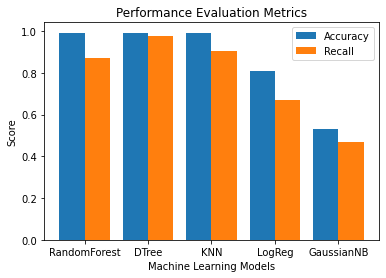

In [61]:
X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, recalls, 0.4, label = 'Recall')
  
plt.xticks(X_axis, models)
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")
plt.title("Performance Evaluation Metrics")
plt.legend()
plt.show()

Box Plot of Accuracy Scores


<AxesSubplot:>

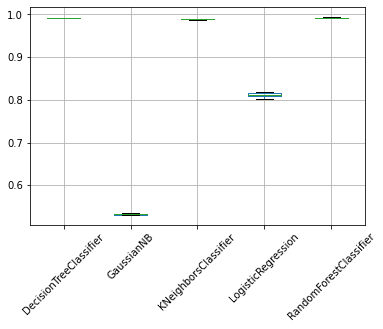

In [63]:
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
print("Box Plot of Accuracy Scores")
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

In [23]:
#Decision Tree
clf = DecisionTreeClassifier() #max_depth=10
clf = clf.fit(binary_train_X, binary_train_y)
clf_predictions = clf.predict(binary_val_X) # make prediction
train_acc = clf.score(binary_train_X, binary_train_y) # mean acc on train data
base_clf_score = accuracy_score(clf_predictions,binary_val_y) # mean acc on test data
print("Training accuracy is:", train_acc*100 )
print("Testing accuracy is:", base_clf_score*100)

Training accuracy is: 99.38675875208382
Testing accuracy is: 99.30540855207451


In [24]:
#Decision Tree Performance Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
Tree_f1 = f1_score(binary_val_y, clf_predictions, average="macro")
Tree_precision = precision_score(binary_val_y, clf_predictions, average="macro")
Tree_recall = recall_score(binary_val_y, clf_predictions, average="macro")
Tree_accuracy = accuracy_score(binary_val_y, clf_predictions)
cm_dtree = confusion_matrix(binary_val_y, clf_predictions)
print('Confusion Matrix: ')
print(cm_dtree)
print("Accuracy Score: ", Tree_f1)
print("Precision Score: ", Tree_precision)
print("Recall Score: ", Tree_recall)
print("F1 Score: ", Tree_accuracy)

Confusion Matrix: 
[[40103   344]
 [  181 34956]]
Accuracy Score:  0.9930217264094496
Precision Score:  0.9928809292549808
Recall Score:  0.9931718889237007
F1 Score:  0.9930540855207451


In [25]:
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # identify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    return prediction_data

<AxesSubplot:>

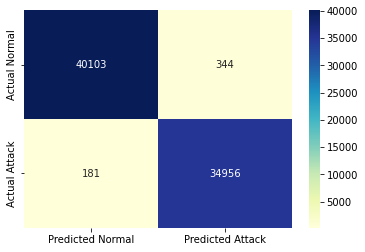

In [26]:
binary_prediction_data = add_predictions(df,
                                         clf_predictions,
                                         binary_val_y)

sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [27]:
# dataframe to store incorrect classification
binary_prediction_data['errors'].describe()

duration     src_bytes     dst_bytes        land  wrong_fragment  \
count    525.000000  5.250000e+02  5.250000e+02  525.000000           525.0   
mean     125.321905  5.035211e+03  8.437288e+03    0.005714             0.0   
std     1412.907518  1.091314e+05  1.683989e+05    0.075448             0.0   
min        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
25%        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
50%        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
75%        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
max    25253.000000  2.500058e+06  3.851730e+06    1.000000             0.0   

           urgent         hot  num_failed_logins   logged_in  num_compromised  \
count  525.000000  525.000000         525.000000  525.000000       525.000000   
mean     0.001905    0.232381           0.024762    0.139048         1.563810   
std      0.043644    1.667865           0.257254    0.346326        33.014718   
min      0.000000    0.000000           0.000000    0.000000         0.000000   
25%      0.000000    0.000000           0.000000    0.000000         0.000000   
50%      0.000000    0.000000           0.000000    0.000000         0.000000   
75%      0.000000    0.000000           0.000000    0.000000         0.000000   
max      1.000000   19.000000           4.000000    1.000000       756.000000   

       ...  dst_host_srv_diff_host_rate  dst_host_serror_rate  \
count  ...                   525.000000            525.000000   
mean   ...                     0.048000              0.095695   
std    ...                     0.157537              0.226304   
min    ...                     0.000000              0.000000   
25%    ...                     0.000000              0.000000   
50%    ...                     0.000000              0.000000   
75%    ...                     0.020000              0.040000   
max    ...                     1.000000              1.000000   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
count                525.000000            525.000000   
mean                   0.029905              0.315810   
std                    0.125879              0.440708   
min                    0.000000              0.000000   
25%                    0.000000              0.000000   
50%                    0.000000              0.010000   
75%                    0.010000              0.940000   
max                    1.000000              1.000000   

       dst_host_srv_rerror_rate       level  attack_flag  attack_map  \
count                525.000000  525.000000   525.000000  525.000000   
mean                   0.338533   15.224762     0.344762    0.556190   
std                    0.456384    5.483055     0.475744    0.926283   
min                    0.000000    0.000000     0.000000    0.000000   
25%                    0.000000   14.000000     0.000000    0.000000   
50%                    0.000000   17.000000     0.000000    0.000000   
75%                    1.000000   19.000000     1.000000    1.000000   
max                    1.000000   21.000000     1.000000    4.000000   

        predicted      actual  
count  525.000000  525.000000  
mean     0.655238    0.344762  
std      0.475744    0.475744  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      1.000000    0.000000  
75%      1.000000    1.000000  
max      1.000000    1.000000  

[8 rows x 43 columns]

A false positive state is when the IDS identifies an activity as an attack but the activity is acceptable behavior. A false positive is a false alarm. A false negative state is the most serious and dangerous state. This is when the IDS identifies an activity as acceptable when the activity is actually an attack.

In [28]:
binary_prediction_data['false_negatives']

duration protocol_type service flag  src_bytes  dst_bytes  land  \
859            0           tcp    http  REJ          0          0     0   
1754           0           tcp    http  REJ          0          0     0   
2006           0           tcp    http  REJ          0          0     0   
3172          98           tcp  telnet   SF        621       8356     0   
3862           0           tcp    http  REJ          0          0     0   
...          ...           ...     ...  ...        ...        ...   ...   
124713         0           tcp    time   SF          0          4     0   
124787         0           tcp    http  REJ          0          0     0   
124813         0           tcp    http  REJ          0          0     0   
125392         0           tcp     X11  REJ          0          0     0   
125454         0           tcp    http  REJ          0          0     0   

        urgent  hot  num_failed_logins  ...  dst_host_serror_rate  \
859          0    0                  0  ...                   0.0   
1754         0    0                  0  ...                   0.0   
2006         0    0                  0  ...                   0.0   
3172         1    1                  0  ...                   0.0   
3862         0    0                  0  ...                   0.0   
...        ...  ...                ...  ...                   ...   
124713       0    0                  0  ...                   0.0   
124787       0    0                  0  ...                   0.0   
124813       0    0                  0  ...                   0.0   
125392       0    0                  0  ...                   0.0   
125454       0    0                  0  ...                   0.0   

        dst_host_srv_serror_rate  dst_host_rerror_rate  \
859                          0.0                  1.00   
1754                         0.0                  1.00   
2006                         0.0                  1.00   
3172                         0.0                  0.00   
3862                         0.0                  1.00   
...                          ...                   ...   
124713                       0.0                  0.94   
124787                       0.0                  1.00   
124813                       0.0                  0.90   
125392                       0.0                  0.01   
125454                       0.0                  1.00   

        dst_host_srv_rerror_rate   attack  level  attack_flag  attack_map  \
859                          1.0  neptune     19            1           1   
1754                         1.0  neptune     20            1           1   
2006                         1.0  neptune     20            1           1   
3172                         0.0  rootkit      1            1           3   
3862                         1.0  neptune     19            1           1   
...                          ...      ...    ...          ...         ...   
124713                       0.0  ipsweep      1            1           2   
124787                       1.0  neptune     20            1           1   
124813                       1.0  ipsweep      7            1           2   
125392                       1.0    satan     16            1           2   
125454                       1.0  neptune     19            1           1   

        predicted  actual  
859           0.0     1.0  
1754          0.0     1.0  
2006          0.0     1.0  
3172          0.0     1.0  
3862          0.0     1.0  
...           ...     ...  
124713        0.0     1.0  
124787        0.0     1.0  
124813        0.0     1.0  
125392        0.0     1.0  
125454        0.0     1.0  

[181 rows x 44 columns]

## Explainable AI with LIME

In [29]:
data = pd.read_csv("KDDtrain.csv")
data.columns = columns
data.drop(['level'], axis=1, inplace=True)
data

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           udp     other   SF        146          0     0   
1              0           tcp   private   S0          0          0     0   
2              0           tcp      http   SF        232       8153     0   
3              0           tcp      http   SF        199        420     0   
4              0           tcp   private  REJ          0          0     0   
...          ...           ...       ...  ...        ...        ...   ...   
125967         0           tcp   private   S0          0          0     0   
125968         8           udp   private   SF        105        145     0   
125969         0           tcp      smtp   SF       2231        384     0   
125970         0           tcp    klogin   S0          0          0     0   
125971         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0  ...                   1   
1                    0       0    0  ...                  26   
2                    0       0    0  ...                 255   
3                    0       0    0  ...                 255   
4                    0       0    0  ...                  19   
...                ...     ...  ...  ...                 ...   
125967               0       0    0  ...                  25   
125968               0       0    0  ...                 244   
125969               0       0    0  ...                  30   
125970               0       0    0  ...                   8   
125971               0       0    0  ...                  77   

        dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                         0.00                    0.60   
1                         0.10                    0.05   
2                         1.00                    0.00   
3                         1.00                    0.00   
4                         0.07                    0.07   
...                        ...                     ...   
125967                    0.10                    0.06   
125968                    0.96                    0.01   
125969                    0.12                    0.06   
125970                    0.03                    0.05   
125971                    0.30                    0.03   

        dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                              0.88                         0.00   
1                              0.00                         0.00   
2                              0.03                         0.04   
3                              0.00                         0.00   
4                              0.00                         0.00   
...                             ...                          ...   
125967                         0.00                         0.00   
125968                         0.01                         0.00   
125969                         0.00                         0.00   
125970                         0.00                         0.00   
125971                         0.30                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.00   
1                       1.00                      1.00                  0.00   
2                       0.03                      0.01                  0.00   
3                       0.00                      0.00                  0.00   
4                       0.00                      0.00                  1.00   
...                      ...                       ...                   ...   
125967                  1.00                      1.00                  0.00   
125968                  0.00                      0.00                  0.00   
125969                  0.72                      0.00                  0.01   


In [30]:
attacks = data['attack'].unique()
attacks

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [31]:
catCols = data.select_dtypes(include = "object").columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feat in catCols:
    data[feat] = le.fit_transform(data[feat].astype(str))
data.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              2       44     9        146          0     0   
1         0              1       49     5          0          0     0   
2         0              1       24     9        232       8153     0   
3         0              1       24     9        199        420     0   
4         0              1       49     1          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   1   
1               0       0    0  ...                  26   
2               0       0    0  ...                 255   
3               0       0    0  ...                 255   
4               0       0    0  ...                  19   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.00                    0.60   
1                    0.10                    0.05   
2                    1.00                    0.00   
3                    1.00                    0.00   
4                    0.07                    0.07   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.88                         0.00   
1                         0.00                         0.00   
2                         0.03                         0.04   
3                         0.00                         0.00   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                   0.0   
1                  1.00                      1.00                   0.0   
2                  0.03                      0.01                   0.0   
3                  0.00                      0.00                   0.0   
4                  0.00                      0.00                   1.0   

   dst_host_srv_rerror_rate  attack  
0                      0.00      11  
1                      0.00       9  
2                      0.01      11  
3                      0.00      11  
4                      1.00       9  

[5 rows x 42 columns]

In [32]:
from sklearn.model_selection import train_test_split
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
y_test

116728    11
92697      9
61133      9
96170     11
4582       9
          ..
66266      9
114908    11
21398     11
84789     11
62907      9
Name: attack, Length: 25195, dtype: int32

In [34]:
model = DecisionTreeClassifier(random_state=18)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=18)

In [28]:
!pip install lime

You should consider upgrading via the 'c:\users\sonali\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [29]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names=attacks,
    mode='classification'
)

In [30]:
y_test.mode() 

0    11
dtype: int32

### LIME interpretation for different attacks in the test dataset


In [31]:
for i in range(1, 5):
    exp = explainer.explain_instance(data_row=x_train.iloc[i], 
                                     predict_fn=model.predict_proba)

    exp.show_in_notebook(show_table=True)

## Explainable AI with SHAP

In [32]:
!pip install shap

You should consider upgrading via the 'c:\users\sonali\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [34]:
import shap
# Fit the SHAP explainer
explainer = shap.Explainer(model.predict, x_test)
# Calculate SHAP values
shap_values = explainer(x_test)

Permutation explainer: 25196it [32:01, 13.11it/s]                                                                      


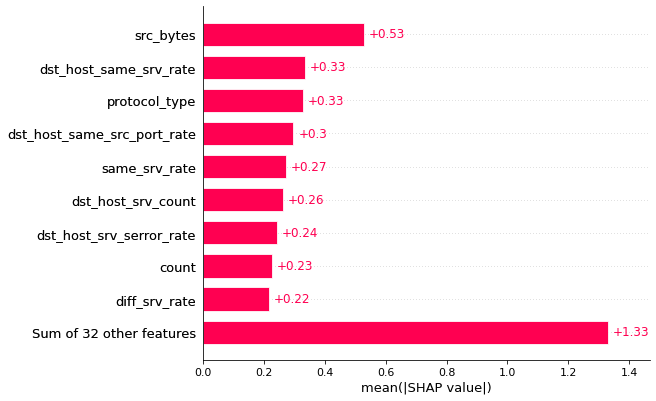

In [36]:
# Bar Plot
shap.plots.bar(shap_values)

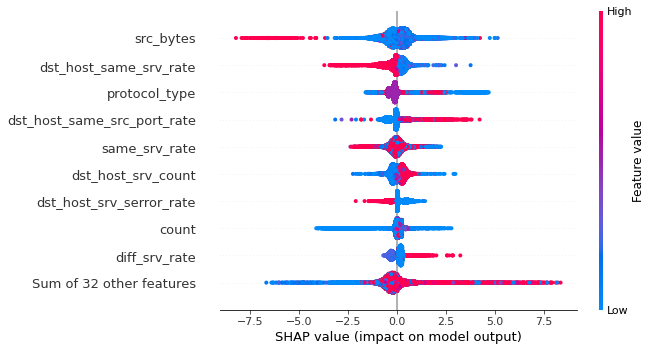

In [37]:
# Summary Plot (Beeswarm)
shap.plots.beeswarm(shap_values)

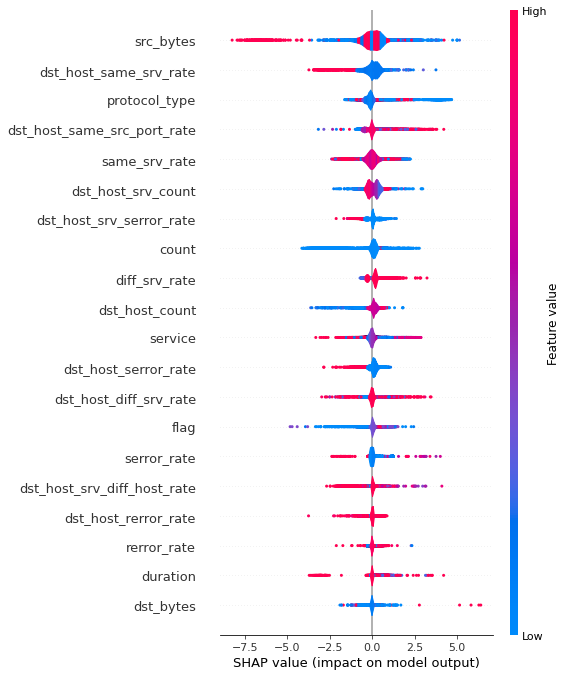

In [38]:
# Summary Plot (Violin)
shap.summary_plot(shap_values, plot_type='violin')

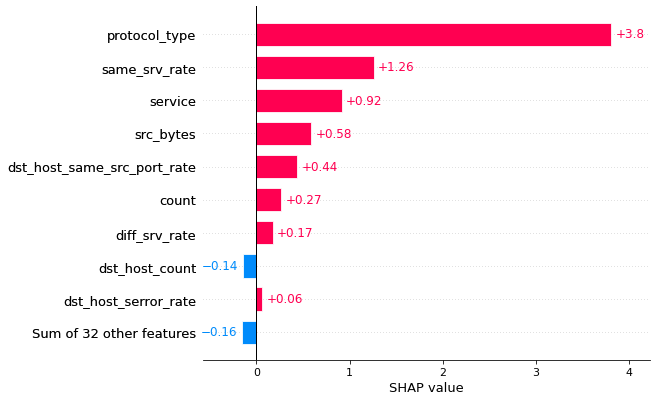

In [39]:
# Local Bar Plot
shap.plots.bar(shap_values[0])

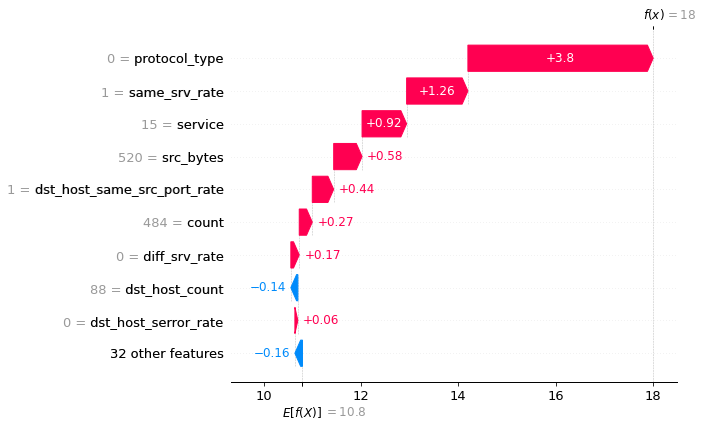

In [40]:
# Waterfall Plot
shap.plots.waterfall(shap_values[0])